I imported libraries, imported the dataset, concatentated the csv files containing energy usage, and then merged the datasets to look up the Acorn of the households. This will allow me to compare usage per group.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import itertools
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Go to directory from link: https://www.kaggle.com/jeanmidev/smart-meters-in-london/notebooks
os.chdir('London_Smart_Meter')

In [3]:
# import household information
ihdf = pd.read_csv('informations_households.csv')

In [4]:
ihdf.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [5]:
ihdf.describe()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
count,5566,5566,5566,5566,5566
unique,5566,2,19,5,112
top,MAC000586,Std,ACORN-E,Affluent,block_63
freq,1,4443,1567,2192,50


In [6]:
# import all of the daily datasets
import glob

path = r'C:\Users\james\Desktop\SpringboardWork\London_Smart_Meter\daily_dataset\corrected'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)


In [7]:
concatenated_df.tail()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
3510428,MAC005019,2014-02-24,0.0915,0.091938,0.192,48,0.029466,4.413,0.046
3510429,MAC005019,2014-02-25,0.0735,0.251104,1.455,48,0.369093,12.053,0.029
3510430,MAC005019,2014-02-26,0.0740,0.117604,0.554,48,0.112632,5.645,0.031
3510431,MAC005019,2014-02-27,0.0605,0.086521,0.449,48,0.076162,4.153,0.029
3510432,MAC005019,2014-02-28,0.0740,0.074000,0.074,1,NaN,0.074,0.074


In [8]:
dfnac = concatenated_df.isna().sum()
dfnac

LCLid                0
day                  0
energy_median       30
energy_mean         30
energy_max          30
energy_count         0
energy_std       11331
energy_sum          30
energy_min          30
dtype: int64

In [9]:
# merge data frames to match data with Acorn and Acorn_grouped
df = pd.merge(concatenated_df, ihdf, on='LCLid', how='left')

In [10]:
df['Day'] = pd.to_datetime(df.day).dt.strftime('%Y-%m-%d')

In [11]:
# It appears that the last day may not be a full day of observations 
# The calculated total energy consumed is far lower than average, and very different from the prior day
# I will drop the last day from the analysis

print('Average Usage for time series: {}'.format(df['energy_sum'][df['day']<'2014-02-28'].sum()/df['day'][df['day']<'2014-02-28'].nunique()))
print('Usage on second to last day: {}'.format(df['energy_sum'][df['day']=='2014-02-27'].sum()))
print('Usage on last day: {}'.format(df['energy_sum'][df['day']=='2014-02-28'].sum()))

Average Usage for time series: 42921.23314056197
Usage on second to last day: 51678.1859978
Usage on last day: 1042.2659999


In [12]:
df = df[df['day'] < '2014-02-28']

In [13]:
df.describe()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,3.505416e+06,3.505416e+06,3.505416e+06,3.505446e+06,3.499102e+06,3.505416e+06,3.505416e+06
mean,1.586680e-01,2.117344e-01,8.354109e-01,4.787022e+01,1.726673e-01,1.013825e+01,5.941328e-02
std,1.696886e-01,1.904395e-01,6.682192e-01,2.189067e+00,1.531208e-01,9.127604e+00,8.569394e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e-02,9.814583e-02,3.460000e-01,4.800000e+01,6.911626e-02,4.695000e+00,2.000000e-02
50%,1.145000e-01,1.633542e-01,6.890000e-01,4.800000e+01,1.327910e-01,7.825000e+00,3.900000e-02
75%,1.910000e-01,2.625000e-01,1.129000e+00,4.800000e+01,2.293124e-01,1.257800e+01,7.100000e-02
max,6.970500e+00,6.928250e+00,1.076100e+01,4.800000e+01,4.024569e+00,3.325560e+02,6.524000e+00


In [14]:
# count the NaNs
dfna = df.isna().sum()
dfna

LCLid               0
day                 0
energy_median      30
energy_mean        30
energy_max         30
energy_count        0
energy_std       6344
energy_sum         30
energy_min         30
stdorToU            0
Acorn               0
Acorn_grouped       0
file                0
Day                 0
dtype: int64

In [15]:
#examine the NaNs
df[df['energy_median'].isna()]

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,stdorToU,Acorn,Acorn_grouped,file,Day
58310,MAC000393,2012-12-18,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-D,Affluent,block_10,2012-12-18
69764,MAC002014,2012-12-18,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-D,Affluent,block_10,2012-12-18
397641,MAC002629,2013-04-16,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-Q,Adversity,block_109,2013-04-16
403985,MAC005556,2012-12-19,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-Q,Adversity,block_109,2012-12-19
403986,MAC005563,2012-12-19,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-Q,Adversity,block_109,2012-12-19
659942,MAC001957,2012-12-18,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-E,Affluent,block_17,2012-12-18
736354,MAC005558,2012-12-19,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-E,Affluent,block_19,2012-12-19
764072,MAC005062,2012-12-18,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-A,Affluent,block_2,2012-12-18
1010470,MAC005037,2013-01-04,NaN,NaN,NaN,0,NaN,NaN,NaN,Std,ACORN-E,Affluent,block_27,2013-01-04
1117678,MAC003559,2013-10-29,NaN,NaN,NaN,0,NaN,NaN,NaN,ToU,ACORN-C,Affluent,block_3,2013-10-29


In [16]:
# I will forward fill NaNs with small count of NaN and because energy usage will likely resemble the prior day's usage
df = df.ffill(axis=0)

In [17]:
dfpiv = pd.pivot_table(df,index=['Day'],aggfunc={'energy_sum':np.sum,'energy_count':'count'})

In [18]:
dfpiv['Total_per_House'] = dfpiv['energy_sum']/dfpiv['energy_count']
dfpiv

,energy_count,energy_sum,Total_per_House
Day,,,
2011-11-23,13,90.385000,6.952692
2011-11-24,25,213.412000,8.536480
2011-11-25,32,303.993000,9.499781
2011-11-26,41,420.976000,10.267707
2011-11-27,41,444.883001,10.850805
...,...,...,...
2014-02-23,4998,57379.092995,11.480411
2014-02-24,4994,51994.547004,10.411403
2014-02-25,4995,51423.508001,10.294997


In [19]:
# create a new dataframe with only Total Energy per household
dfe = dfpiv[['Total_per_House']]
dfe

,Total_per_House
Day,
2011-11-23,6.952692
2011-11-24,8.536480
2011-11-25,9.499781
2011-11-26,10.267707
2011-11-27,10.850805
...,...
2014-02-23,11.480411
2014-02-24,10.411403
2014-02-25,10.294997


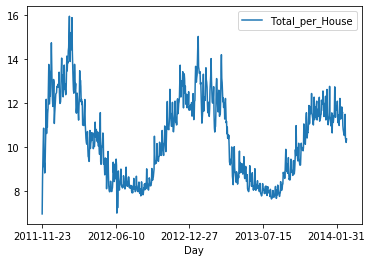

In [20]:
dfe.plot()

In [21]:
# find the date to split train/test and set to variable
n = dfe.iloc[round(len(dfe)*.7)]
nn = round(len(dfe)*.7)
nn

580

In [22]:
# create a new data frame that takes the sum and count of elements so to calculate the total energy per household
for i in df.Acorn_grouped.unique():
    x = df[df.Acorn_grouped==i]
    x1 = x.groupby(['Day']).sum()
    x2 = x.groupby(['Day']).count()
    x3 = pd.merge(x1, x2, on='Day', how='inner', suffixes=("_sum", "_count"))
    x3[i] = x3['energy_sum_sum']/x3['energy_sum_count']
    dfe = pd.merge(dfe, x3[i], on='Day', how='left')

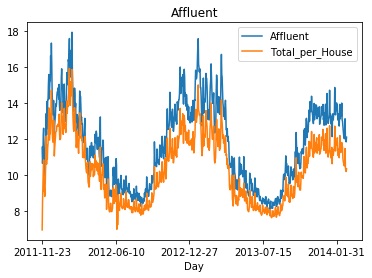

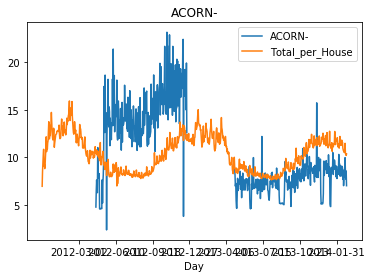

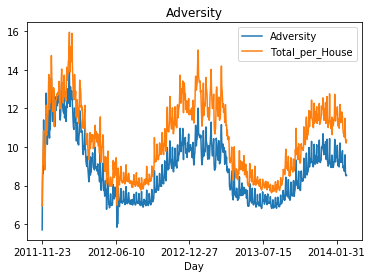

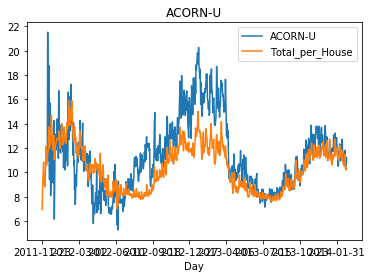

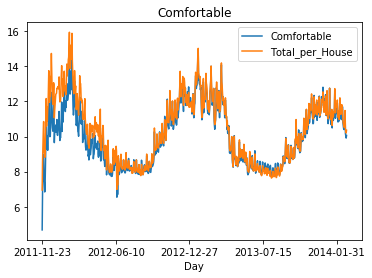

In [23]:
# use visualizations to compare each group to the overall average
for i in dfe.columns[1:]:
    dfe[i].plot(legend=True)
    dfe['Total_per_House'].plot(title=i,legend=True)
    plt.show()

Now I will add in the weather data to use an exogenous variable to help predict energy usage

In [24]:
weather = pd.read_csv('weather_hourly_darksky.csv')
weather.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [25]:
weather['Day'] = pd.to_datetime(weather.time).dt.strftime('%Y-%m-%d')

In [26]:
weather.tail()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary,Day
21160,12.68,247,7.39,2014-02-15 19:00:00,3.06,997.07,3.91,6.08,rain,partly-cloudy-night,0.74,Partly Cloudy,2014-02-15
21161,13.78,249,6.56,2014-02-15 20:00:00,2.76,998.15,3.03,5.61,rain,clear-night,0.77,Clear,2014-02-15
21162,14.31,248,6.47,2014-02-15 21:00:00,2.71,999.28,3.06,5.25,rain,clear-night,0.77,Clear,2014-02-15
21163,14.31,248,5.96,2014-02-15 22:00:00,2.69,1000.33,2.68,4.69,rain,clear-night,0.80,Clear,2014-02-15
21164,14.31,246,5.38,2014-02-15 23:00:00,2.60,1001.25,1.77,5.09,rain,clear-night,0.82,Clear,2014-02-15


In [27]:
wdf = pd.pivot_table(weather,index='Day',aggfunc={'temperature':np.mean})
wdf.columns = ['Average_Temperature']
wdf

,Average_Temperature
Day,
2011-11-01,12.907083
2011-11-02,12.343333
2011-11-03,15.307083
2011-11-04,13.467500
2011-11-05,12.204583
...,...
2014-03-27,6.058333
2014-03-28,8.262083
2014-03-29,12.502917


In [28]:
wdf.dtypes

Average_Temperature    float64
dtype: object

In [29]:
dff = dfe.join(wdf, how='inner')

In [30]:
dff

,Total_per_House,Affluent,ACORN-,Adversity,ACORN-U,Comfortable,Average_Temperature
Day,,,,,,,
2011-11-23,6.952692,11.551500,NaN,5.708500,NaN,4.680286,7.442083
2011-11-24,8.536480,10.654900,NaN,8.250750,NaN,6.714545,10.377083
2011-11-25,9.499781,11.062214,NaN,8.989333,NaN,7.932167,10.851667
2011-11-26,10.267707,12.207176,NaN,8.646714,NaN,8.995706,10.227083
2011-11-27,10.850805,12.611000,NaN,11.401429,NaN,8.863882,10.832083
...,...,...,...,...,...,...,...
2014-02-23,11.480411,13.138394,9.966,9.594565,11.818762,11.413191,10.328750
2014-02-24,10.411403,12.049698,8.402,8.698425,10.463186,10.171652,10.570000
2014-02-25,10.294997,11.980616,7.718,8.529100,10.595512,10.043865,8.760417


In [31]:
# count the NaNs
dffna = dff.isna().sum()
dffna

Total_per_House          0
Affluent                 0
ACORN-                 275
Adversity                0
ACORN-U                 14
Comfortable              0
Average_Temperature      0
dtype: int64

In [32]:
# Drop ACORN-_x and ACORN-_y
dff = dff.drop(dff.loc[:,['ACORN-','ACORN-U']], axis=1)

In [33]:
dff

,Total_per_House,Affluent,Adversity,Comfortable,Average_Temperature
Day,,,,,
2011-11-23,6.952692,11.551500,5.708500,4.680286,7.442083
2011-11-24,8.536480,10.654900,8.250750,6.714545,10.377083
2011-11-25,9.499781,11.062214,8.989333,7.932167,10.851667
2011-11-26,10.267707,12.207176,8.646714,8.995706,10.227083
2011-11-27,10.850805,12.611000,11.401429,8.863882,10.832083
...,...,...,...,...,...
2014-02-23,11.480411,13.138394,9.594565,11.413191,10.328750
2014-02-24,10.411403,12.049698,8.698425,10.171652,10.570000
2014-02-25,10.294997,11.980616,8.529100,10.043865,8.760417


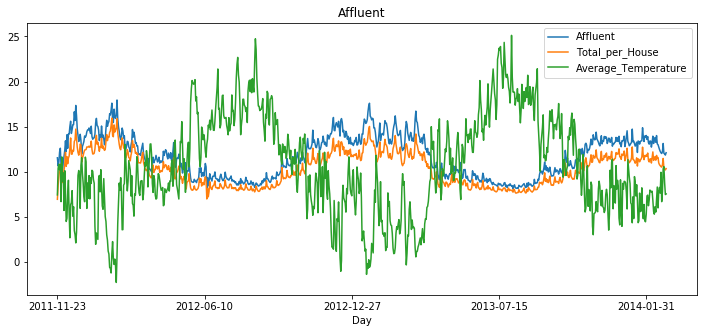

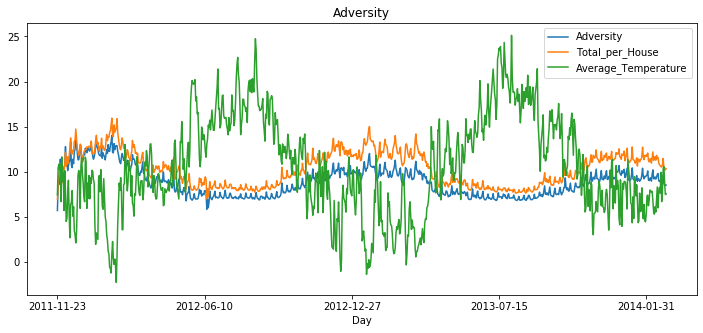

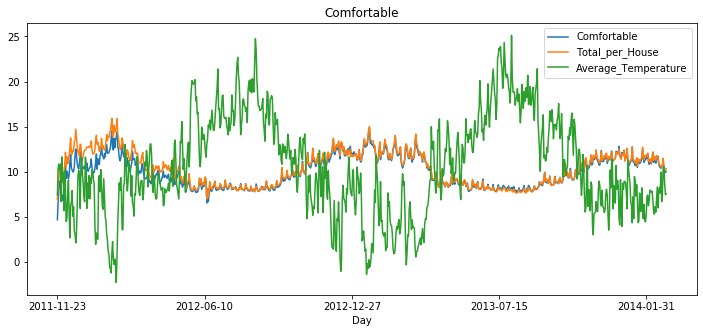

In [34]:
# use visualizations to compare each group to the overall average, adding temperature
for i in dff.columns[1:-1]:
    dff[i].plot(legend=True, figsize=(12,5))
    dff['Total_per_House'].plot(title=i,legend=True)
    dff['Average_Temperature'].plot(legend=True)
    plt.show()

In [35]:
#import stats models and Augmented Dicky Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()


    #Plot rolling statistics:
    fig = plt.figure(figsize=(6, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test for:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(timeseries)
    if dfoutput['p-value'] <= 0.05:
        print(f" Series is Stationary")
    else:
        print(f"Series is Not Stationary")    
    print (dfoutput)

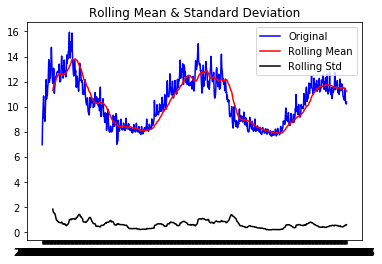

Results of Dickey-Fuller Test for:
Day
2011-11-23     6.952692
2011-11-24     8.536480
2011-11-25     9.499781
2011-11-26    10.267707
2011-11-27    10.850805
                ...    
2014-02-23    11.480411
2014-02-24    10.411403
2014-02-25    10.294997
2014-02-26    10.202945
2014-02-27    10.356350
Name: Total_per_House, Length: 828, dtype: float64
Series is Not Stationary
Test Statistic                  -2.039336
p-value                          0.269596
#Lags Used                      21.000000
Number of Observations Used    806.000000
Critical Value (1%)             -3.438489
Critical Value (5%)             -2.865133
Critical Value (10%)            -2.568683
dtype: float64


In [36]:
test_stationarity(dff['Total_per_House'])

In [37]:
#Calculate Yearly Shift for Naive analysis
# irrelevant?tdd = dff['Total_per_House'] - dff['Total_per_House'].shift(365)
# irrelevant?tdd = tdd.dropna()
# irrelevant?tdd
for i in dff.columns:
    x = str(i) + '_Yr_Shift'
    dff[x] = dff[i].shift(365)
dff


,Total_per_House,Affluent,Adversity,Comfortable,Average_Temperature,Total_per_House_Yr_Shift,Affluent_Yr_Shift,Adversity_Yr_Shift,Comfortable_Yr_Shift,Average_Temperature_Yr_Shift
Day,,,,,,,,,,
2011-11-23,6.952692,11.551500,5.708500,4.680286,7.442083,NaN,NaN,NaN,NaN,NaN
2011-11-24,8.536480,10.654900,8.250750,6.714545,10.377083,NaN,NaN,NaN,NaN,NaN
2011-11-25,9.499781,11.062214,8.989333,7.932167,10.851667,NaN,NaN,NaN,NaN,NaN
2011-11-26,10.267707,12.207176,8.646714,8.995706,10.227083,NaN,NaN,NaN,NaN,NaN
2011-11-27,10.850805,12.611000,11.401429,8.863882,10.832083,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2014-02-23,11.480411,13.138394,9.594565,11.413191,10.328750,13.245570,15.355745,10.700636,13.141575,0.970000
2014-02-24,10.411403,12.049698,8.698425,10.171652,10.570000,14.014282,16.194175,11.288121,14.003030,1.586250
2014-02-25,10.294997,11.980616,8.529100,10.043865,8.760417,13.059055,15.394097,10.347595,12.758555,3.192917


In [38]:
# Calculate the yearly difference
for i in range(0,5):
    x = dff.columns[i]
    y = x + '_diff_yr'
    dff[y] = dff.iloc[:,i] - dff.iloc[:,i+5]
dff


,Total_per_House,Affluent,Adversity,Comfortable,Average_Temperature,Total_per_House_Yr_Shift,Affluent_Yr_Shift,Adversity_Yr_Shift,Comfortable_Yr_Shift,Average_Temperature_Yr_Shift,Total_per_House_diff_yr,Affluent_diff_yr,Adversity_diff_yr,Comfortable_diff_yr,Average_Temperature_diff_yr
Day,,,,,,,,,,,,,,,
2011-11-23,6.952692,11.551500,5.708500,4.680286,7.442083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,8.536480,10.654900,8.250750,6.714545,10.377083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,9.499781,11.062214,8.989333,7.932167,10.851667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,10.267707,12.207176,8.646714,8.995706,10.227083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,10.850805,12.611000,11.401429,8.863882,10.832083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-23,11.480411,13.138394,9.594565,11.413191,10.328750,13.245570,15.355745,10.700636,13.141575,0.970000,-1.765159,-2.217350,-1.106071,-1.728384,9.358750
2014-02-24,10.411403,12.049698,8.698425,10.171652,10.570000,14.014282,16.194175,11.288121,14.003030,1.586250,-3.602879,-4.144477,-2.589697,-3.831378,8.983750
2014-02-25,10.294997,11.980616,8.529100,10.043865,8.760417,13.059055,15.394097,10.347595,12.758555,3.192917,-2.764059,-3.413480,-1.818495,-2.714690,5.567500


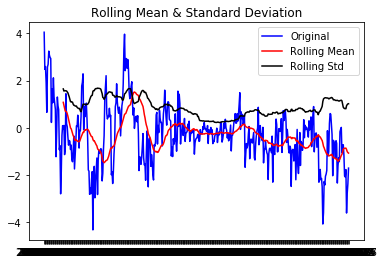

Results of Dickey-Fuller Test for:
Day
2012-11-22    4.046359
2012-11-23    2.478225
2012-11-24    2.595134
2012-11-25    1.918099
2012-11-26    0.657428
                ...   
2014-02-23   -1.765159
2014-02-24   -3.602879
2014-02-25   -2.764059
2014-02-26   -2.370387
2014-02-27   -1.702410
Name: Total_per_House_diff_yr, Length: 463, dtype: float64
 Series is Stationary
Test Statistic                  -4.771128
p-value                          0.000062
#Lags Used                      14.000000
Number of Observations Used    448.000000
Critical Value (1%)             -3.445031
Critical Value (5%)             -2.868013
Critical Value (10%)            -2.570218
dtype: float64


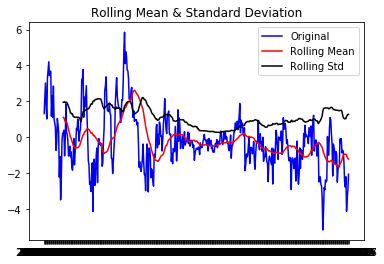

Results of Dickey-Fuller Test for:
Day
2012-11-22    1.312537
2012-11-23    2.177963
2012-11-24    3.018183
2012-11-25    1.798282
2012-11-26    1.011614
                ...   
2014-02-23   -2.217350
2014-02-24   -4.144477
2014-02-25   -3.413480
2014-02-26   -2.954440
2014-02-27   -2.073609
Name: Affluent_diff_yr, Length: 463, dtype: float64
 Series is Stationary
Test Statistic                  -4.624313
p-value                          0.000116
#Lags Used                      14.000000
Number of Observations Used    448.000000
Critical Value (1%)             -3.445031
Critical Value (5%)             -2.868013
Critical Value (10%)            -2.570218
dtype: float64


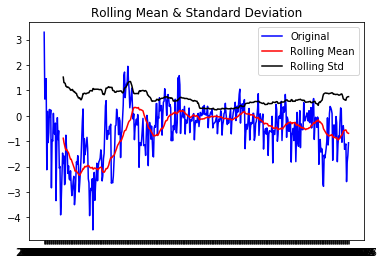

Results of Dickey-Fuller Test for:
Day
2012-11-22    3.289357
2012-11-23    0.658653
2012-11-24    0.877223
2012-11-25    1.463476
2012-11-26   -2.122936
                ...   
2014-02-23   -1.106071
2014-02-24   -2.589697
2014-02-25   -1.818495
2014-02-26   -1.551567
2014-02-27   -1.059002
Name: Adversity_diff_yr, Length: 463, dtype: float64
Series is Not Stationary
Test Statistic                  -2.799948
p-value                          0.058281
#Lags Used                      14.000000
Number of Observations Used    448.000000
Critical Value (1%)             -3.445031
Critical Value (5%)             -2.868013
Critical Value (10%)            -2.570218
dtype: float64


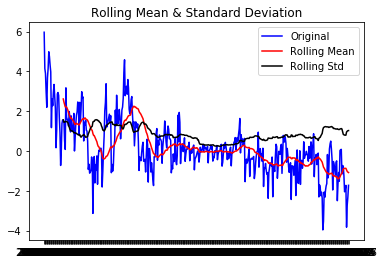

Results of Dickey-Fuller Test for:
Day
2012-11-22    5.970460
2012-11-23    4.147269
2012-11-24    3.894233
2012-11-25    2.958227
2012-11-26    2.197452
                ...   
2014-02-23   -1.728384
2014-02-24   -3.831378
2014-02-25   -2.714690
2014-02-26   -2.306831
2014-02-27   -1.725888
Name: Comfortable_diff_yr, Length: 463, dtype: float64
 Series is Stationary
Test Statistic                  -3.090611
p-value                          0.027256
#Lags Used                      14.000000
Number of Observations Used    448.000000
Critical Value (1%)             -3.445031
Critical Value (5%)             -2.868013
Critical Value (10%)            -2.570218
dtype: float64


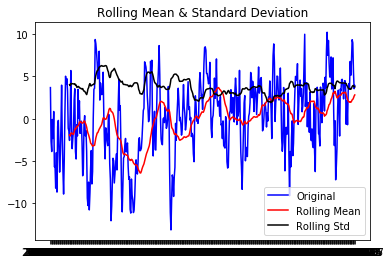

Results of Dickey-Fuller Test for:
Day
2012-11-22    3.682917
2012-11-23   -2.693333
2012-11-24   -3.894583
2012-11-25   -0.096250
2012-11-26   -2.345833
                ...   
2014-02-23    9.358750
2014-02-24    8.983750
2014-02-25    5.567500
2014-02-26    3.554583
2014-02-27    3.927083
Name: Average_Temperature_diff_yr, Length: 463, dtype: float64
 Series is Stationary
Test Statistic                  -4.943206
p-value                          0.000029
#Lags Used                       6.000000
Number of Observations Used    456.000000
Critical Value (1%)             -3.444772
Critical Value (5%)             -2.867899
Critical Value (10%)            -2.570157
dtype: float64


In [39]:
# test stationarity of the Yearly difference series
for i in dff.columns[-5:]:
    x = dff[i].dropna()
    test_stationarity(x)

C:\Users\james\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


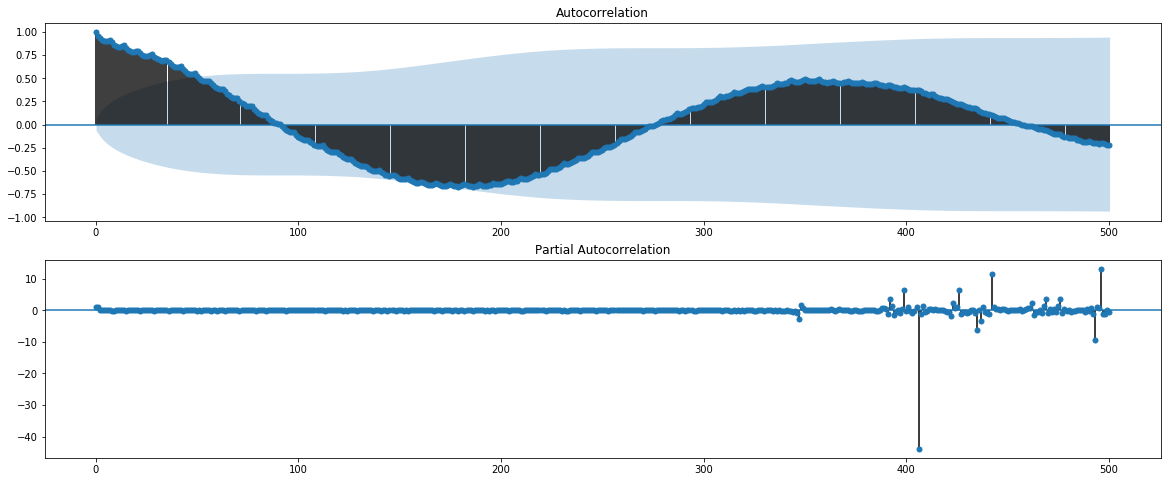

In [40]:
#plot the auto-correlation and partial auto-correlation to better understand the dataset
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(2,1, figsize=(20,8))
fig = sm.graphics.tsa.plot_acf(dff['Total_per_House'], lags=500, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dff['Total_per_House'], lags=500, ax=ax[1])
plt.show()

In [41]:
# Calculate the Mean Average Error using the naive prediction (simple 1 year shift)
naive_mean_av_error = np.mean(np.abs(dff['Total_per_House_Yr_Shift'][nn:] - dff['Total_per_House'][nn:]))
naive_mean_av_error


0.7072798006196777

In [42]:
#irrelevant?ysd = dff[['Total_per_House_Yr_Shift']].dropna()
# irrelevant?xsd = dff[['Average_Temperature_Yr_Shift']].dropna()

In [43]:
# generate the combinations of parameters for the gridsearches
import itertools
p = q = range(0, 2)
d = range(0,3)
pdq = list(itertools.product(p,d,q))
pdq
ds = qs = range(0,2)
ps = range(0, 2)
ss = [12]
pdqs = list(itertools.product(ps, ds, qs, ss))

In [44]:
# Define functions to test a few models: Sarimax with seasonal order and exogenous variable of temperature,
#Sarima without exogenous variable and arimas without seasonal order
def sarimax_gridsearch(ts, ex, pdq, pdqs, maxiter=50, freq='D'):

    
    #Input: 
        #ts : your time series data
        #ex : exogenous variable
        #pdq : ARIMA combinations from above
        #pdqs : seasonal ARIMA combinations from above
        #maxiter : number of iterations, increase if model isn't converging
        #frequency : default='D' for month. Change to suit  time series frequency
        #    e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    #Return:
        #Prints out top 5 parameter combinations
        #Returns dataframe of parameter combinations ranked by BIC


    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                ex = ex,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
                #mod = sm.tsa.statespace.SARIMAX(ts, ex, comb, combs, freq='D')

                output = mod.fit() 
                ans.append([comb, combs, output.bic, output.aic])
                print('SARIMAX {} x {} : BIC Calculated ={}'.format(comb, combs, output.bic, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df



# Repeat process without exogenous variable
def sarima_gridsearch(ts, pdq, pdqs, maxiter=50, freq='D'):

    
    #Input: 
        #ts : your time series data
        #ex : exogenous variable
        #pdq : ARIMA combinations from above
        #pdqs : seasonal ARIMA combinations from above
        #maxiter : number of iterations, increase if your model isn't converging
        #frequency : default='M' for month. Change to suit your time series frequency
        #    e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    #Return:
        #Prints out top 5 parameter combinations
        #Returns dataframe of parameter combinations ranked by BIC


    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
               

                output = mod.fit() 
                ans.append([comb, combs, output.bic, output.aic])
                print('SARIMA {} x {} : BIC Calculated ={}'.format(comb, combs, output.bic, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df


# Define function
def arima_gridsearch(ts, ex, pdq, maxiter=50, freq='D'):

    
    #Input: 
        #ts : your time series data
        #ex : exogenous variable
        #pdq : ARIMA combinations from above
        #pdqs : seasonal ARIMA combinations from above
        #maxiter : number of iterations, increase if your model isn't converging
        #frequency : default='M' for month. Change to suit your time series frequency
        #    e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    #Return:
        #Prints out top 5 parameter combinations
        #Returns dataframe of parameter combinations ranked by BIC


    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            ex = ex,
                                            order=comb,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            freq=freq)
                #mod = sm.tsa.statespace.SARIMAX(ts, ex, comb, combs, freq='D')

            output = mod.fit() 
            ans.append([comb, output.bic, output.aic])
            print('ARIMAX {} x {} : BIC Calculated ={}'.format(comb, output.bic, output.aic))
        except:
            continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    b1 = ans_df.iloc[0,0]
    arima_mod = sm.tsa.statespace.SARIMAX(ts, ex, comb, freq='D')
    return ans_df

In [45]:
# Apply full SARIMAX model with seasonal order and temperature as exogenous variable
sarimax_gridsearch(dff[['Total_per_House_diff_yr']][:nn].dropna(), dff[['Average_Temperature_diff_yr']][:nn].dropna(), pdq, pdqs, freq='D')

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (0, 0, 0, 12) : BIC Calculated =765.977567045441
SARIMAX (0, 0, 0) x (0, 0, 1, 12) : BIC Calculated =701.3172280213258
SARIMAX (0, 0, 0) x (0, 1, 0, 12) : BIC Calculated =827.7246165436293


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (0, 1, 1, 12) : BIC Calculated =721.4252407768791
SARIMAX (0, 0, 0) x (1, 0, 0, 12) : BIC Calculated =704.0638976531878
SARIMAX (0, 0, 0) x (1, 0, 1, 12) : BIC Calculated =706.1283004432639


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (1, 1, 0, 12) : BIC Calculated =771.5496620880555


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (1, 1, 1, 12) : BIC Calculated =705.8403614775474
SARIMAX (0, 0, 1) x (0, 0, 0, 12) : BIC Calculated =637.3841305441708
SARIMAX (0, 0, 1) x (0, 0, 1, 12) : BIC Calculated =581.8644316098955


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 1, 0, 12) : BIC Calculated =692.269856418843
SARIMAX (0, 0, 1) x (0, 1, 1, 12) : BIC Calculated =605.8620925261706
SARIMAX (0, 0, 1) x (1, 0, 0, 12) : BIC Calculated =584.6686137649209


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 0, 1, 12) : BIC Calculated =585.0817569570422
SARIMAX (0, 0, 1) x (1, 1, 0, 12) : BIC Calculated =650.9628924000795


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 1, 1, 12) : BIC Calculated =587.7926370330739
SARIMAX (0, 1, 0) x (0, 0, 0, 12) : BIC Calculated =553.2678064986814
SARIMAX (0, 1, 0) x (0, 0, 1, 12) : BIC Calculated =518.6504229545836
SARIMAX (0, 1, 0) x (0, 1, 0, 12) : BIC Calculated =652.3378406854547

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (0, 1, 1, 12) : BIC Calculated =533.9485518653488
SARIMAX (0, 1, 0) x (1, 0, 0, 12) : BIC Calculated =520.7714731399253


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 0, 1, 12) : BIC Calculated =520.7548896329706
SARIMAX (0, 1, 0) x (1, 1, 0, 12) : BIC Calculated =571.4880700739144


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 1, 1, 12) : BIC Calculated =533.4209460017354
SARIMAX (0, 1, 1) x (0, 0, 0, 12) : BIC Calculated =546.7200299791759
SARIMAX (0, 1, 1) x (0, 0, 1, 12) : BIC Calculated =512.63532566397


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 1, 0, 12) : BIC Calculated =652.1657858864536


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 1, 1, 12) : BIC Calculated =523.5146248462898
SARIMAX (0, 1, 1) x (1, 0, 0, 12) : BIC Calculated =517.820666296215


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 0, 1, 12) : BIC Calculated =515.0578504275381
SARIMAX (0, 1, 1) x (1, 1, 0, 12) : BIC Calculated =572.7418443829946


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 1, 1, 12) : BIC Calculated =526.824410259585
SARIMAX (0, 2, 0) x (0, 0, 0, 12) : BIC Calculated =735.5350825088301
SARIMAX (0, 2, 0) x (0, 0, 1, 12) : BIC Calculated =685.5084409331706


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (0, 1, 0, 12) : BIC Calculated =803.3432838361074


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (0, 1, 1, 12) : BIC Calculated =697.4786629593092
SARIMAX (0, 2, 0) x (1, 0, 0, 12) : BIC Calculated =687.9570135984222
SARIMAX (0, 2, 0) x (1, 0, 1, 12) : BIC Calculated =686.6689871993286

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (0, 2, 0) x (1, 1, 0, 12) : BIC Calculated =723.4428888742162


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (1, 1, 1, 12) : BIC Calculated =695.736624451761
SARIMAX (0, 2, 1) x (0, 0, 0, 12) : BIC Calculated =560.9319195369732


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 0, 1, 12) : BIC Calculated =522.740082725411
SARIMAX (0, 2, 1) x (0, 1, 0, 12) : BIC Calculated =657.4673537682825


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 1, 1, 12) : BIC Calculated =536.8712820473439


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 0, 0, 12) : BIC Calculated =529.3851215623833


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 0, 1, 12) : BIC Calculated =526.2174111098317


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 1, 0, 12) : BIC Calculated =579.9668726375804


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 1, 1, 12) : BIC Calculated =539.2235562912252
SARIMAX (1, 0, 0) x (0, 0, 0, 12) : BIC Calculated =538.5185552408582
SARIMAX (1, 0, 0) x (0, 0, 1, 12) : BIC Calculated =504.0714905476132


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (0, 1, 0, 12) : BIC Calculated =637.0516016464069
SARIMAX (1, 0, 0) x (0, 1, 1, 12) : BIC Calculated =519.9535928027705
SARIMAX (1, 0, 0) x (1, 0, 0, 12) : BIC Calculated =503.9822475529965


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 0, 1, 12) : BIC Calculated =507.112390898818
SARIMAX (1, 0, 0) x (1, 1, 0, 12) : BIC Calculated =557.9688773552979


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 1, 1, 12) : BIC Calculated =520.3188412439713
SARIMAX (1, 0, 1) x (0, 0, 0, 12) : BIC Calculated =538.5399490254481


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 0, 1, 12) : BIC Calculated =506.24190328367825
SARIMAX (1, 0, 1) x (0, 1, 0, 12) : BIC Calculated =639.7192399459541


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 1, 1, 12) : BIC Calculated =516.4800452714984
SARIMAX (1, 0, 1) x (1, 0, 0, 12) : BIC Calculated =507.90479972745396


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 0, 1, 12) : BIC Calculated =508.9329471310644


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 0, 12) : BIC Calculated =562.5157270621199


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 1, 12) : BIC Calculated =518.5818563277807
SARIMAX (1, 1, 0) x (0, 0, 0, 12) : BIC Calculated =550.5192292303655
SARIMAX (1, 1, 0) x (0, 0, 1, 12) : BIC Calculated =517.3104480222858


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 1, 0, 12) : BIC Calculated =656.4159939590974


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 1, 1, 12) : BIC Calculated =527.4207981157625
SARIMAX (1, 1, 0) x (1, 0, 0, 12) : BIC Calculated =517.8960141460461


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 0, 1, 12) : BIC Calculated =519.4339713299955
SARIMAX (1, 1, 0) x (1, 1, 0, 12) : BIC Calculated =570.4852835810924


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 1, 1, 12) : BIC Calculated =532.6861836620054
SARIMAX (1, 1, 1) x (0, 0, 0, 12) : BIC Calculated =546.2364202042003


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 0, 1, 12) : BIC Calculated =508.9740540329838


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 0, 12) : BIC Calculated =642.6756823805633


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 1, 12) : BIC Calculated =526.0807291106406


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 0, 12) : BIC Calculated =512.6421058296617


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 1, 12) : BIC Calculated =514.3755223887731


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 0, 12) : BIC Calculated =566.5765436635182


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 1, 12) : BIC Calculated =528.3681769854463
SARIMAX (1, 2, 0) x (0, 0, 0, 12) : BIC Calculated =663.8343739544488
SARIMAX (1, 2, 0) x (0, 0, 1, 12) : BIC Calculated =622.3470365479045


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (0, 1, 0, 12) : BIC Calculated =770.699943244391
SARIMAX (1, 2, 0) x (0, 1, 1, 12) : BIC Calculated =628.3213815574369
SARIMAX (1, 2, 0) x (1, 0, 0, 12) : BIC Calculated =623.4325852652851


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 0, 1, 12) : BIC Calculated =625.0699025708531
SARIMAX (1, 2, 0) x (1, 1, 0, 12) : BIC Calculated =660.2790580142915


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 1, 1, 12) : BIC Calculated =633.5839207996204
SARIMAX (1, 2, 1) x (0, 0, 0, 12) : BIC Calculated =557.2045989958924


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 0, 1, 12) : BIC Calculated =522.0676084125598
SARIMAX (1, 2, 1) x (0, 1, 0, 12) : BIC Calculated =661.601423142452


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 1, 1, 12) : BIC Calculated =530.1494685080612


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 0, 0, 12) : BIC Calculated =525.4524604558387


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 0, 1, 12) : BIC Calculated =525.8119357488505


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 1, 0, 12) : BIC Calculated =578.5040319530665


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 1, 1, 12) : BIC Calculated =537.7119575651702


,pdq,pdqs,bic,aic
52,"(1, 0, 0)","(1, 0, 0, 12)",503.982248,494.057444
49,"(1, 0, 0)","(0, 0, 1, 12)",504.071491,494.146687
57,"(1, 0, 1)","(0, 0, 1, 12)",506.241903,493.028684
53,"(1, 0, 0)","(1, 0, 1, 12)",507.112391,493.879320
60,"(1, 0, 1)","(1, 0, 0, 12)",507.904800,494.671729


In [46]:
sarima_gridsearch(dff[['Total_per_House_diff_yr']][:nn].dropna(), pdq, pdqs, freq='D')

SARIMA (0, 0, 0) x (0, 0, 0, 12) : BIC Calculated =765.977567045441
SARIMA (0, 0, 0) x (0, 0, 1, 12) : BIC Calculated =701.3172280213258


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 0, 0) x (0, 1, 0, 12) : BIC Calculated =827.7246165436293
SARIMA (0, 0, 0) x (0, 1, 1, 12) : BIC Calculated =721.4252407768791
SARIMA (0, 0, 0) x (1, 0, 0, 12) : BIC Calculated =704.0638976531878
SARIMA (0, 0, 0) x (1, 0, 1, 12) : BIC Calculated =706.1283004432639


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 0, 0) x (1, 1, 0, 12) : BIC Calculated =771.5496620880555


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 0, 0) x (1, 1, 1, 12) : BIC Calculated =705.8403614775474
SARIMA (0, 0, 1) x (0, 0, 0, 12) : BIC Calculated =637.3841305441708
SARIMA (0, 0, 1) x (0, 0, 1, 12) : BIC Calculated =581.8644316098955


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 0, 1) x (0, 1, 0, 12) : BIC Calculated =692.269856418843


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 0, 1) x (0, 1, 1, 12) : BIC Calculated =605.8620925261706
SARIMA (0, 0, 1) x (1, 0, 0, 12) : BIC Calculated =584.6686137649209


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 0, 1) x (1, 0, 1, 12) : BIC Calculated =585.0817569570422


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 0, 1) x (1, 1, 0, 12) : BIC Calculated =650.9628924000795


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 0, 1) x (1, 1, 1, 12) : BIC Calculated =587.7926370330739
SARIMA (0, 1, 0) x (0, 0, 0, 12) : BIC Calculated =553.2678064986814
SARIMA (0, 1, 0) x (0, 0, 1, 12) : BIC Calculated =518.6504229545836


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 1, 0) x (0, 1, 0, 12) : BIC Calculated =652.3378406854547


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 1, 0) x (0, 1, 1, 12) : BIC Calculated =533.9485518653488
SARIMA (0, 1, 0) x (1, 0, 0, 12) : BIC Calculated =520.7714731399253


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 1, 0) x (1, 0, 1, 12) : BIC Calculated =520.7548896329706
SARIMA (0, 1, 0) x (1, 1, 0, 12) : BIC Calculated =571.4880700739144


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 1, 0) x (1, 1, 1, 12) : BIC Calculated =533.4209460017354
SARIMA (0, 1, 1) x (0, 0, 0, 12) : BIC Calculated =546.7200299791759
SARIMA (0, 1, 1) x (0, 0, 1, 12) : BIC Calculated =512.63532566397


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 1, 1) x (0, 1, 0, 12) : BIC Calculated =652.1657858864536


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 1, 1) x (0, 1, 1, 12) : BIC Calculated =523.5146248462898
SARIMA (0, 1, 1) x (1, 0, 0, 12) : BIC Calculated =517.820666296215

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMA (0, 1, 1) x (1, 0, 1, 12) : BIC Calculated =515.0578504275381
SARIMA (0, 1, 1) x (1, 1, 0, 12) : BIC Calculated =572.7418443829946


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 1, 1) x (1, 1, 1, 12) : BIC Calculated =526.824410259585
SARIMA (0, 2, 0) x (0, 0, 0, 12) : BIC Calculated =735.5350825088301
SARIMA (0, 2, 0) x (0, 0, 1, 12) : BIC Calculated =685.5084409331706
SARIMA (0, 2, 0) x (0, 1, 0, 12) : BIC Calculated =803.3432838361074

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMA (0, 2, 0) x (0, 1, 1, 12) : BIC Calculated =697.4786629593092
SARIMA (0, 2, 0) x (1, 0, 0, 12) : BIC Calculated =687.9570135984222


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 0) x (1, 0, 1, 12) : BIC Calculated =686.6689871993286
SARIMA (0, 2, 0) x (1, 1, 0, 12) : BIC Calculated =723.4428888742162


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 0) x (1, 1, 1, 12) : BIC Calculated =695.736624451761
SARIMA (0, 2, 1) x (0, 0, 0, 12) : BIC Calculated =560.9319195369732


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 1) x (0, 0, 1, 12) : BIC Calculated =522.740082725411


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 1) x (0, 1, 0, 12) : BIC Calculated =657.4673537682825


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 1) x (0, 1, 1, 12) : BIC Calculated =536.8712820473439


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 1) x (1, 0, 0, 12) : BIC Calculated =529.3851215623833


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 1) x (1, 0, 1, 12) : BIC Calculated =526.2174111098317


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 1) x (1, 1, 0, 12) : BIC Calculated =579.9668726375804


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (0, 2, 1) x (1, 1, 1, 12) : BIC Calculated =539.2235562912252
SARIMA (1, 0, 0) x (0, 0, 0, 12) : BIC Calculated =538.5185552408582
SARIMA (1, 0, 0) x (0, 0, 1, 12) : BIC Calculated =504.0714905476132


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 0, 0) x (0, 1, 0, 12) : BIC Calculated =637.0516016464069
SARIMA (1, 0, 0) x (0, 1, 1, 12) : BIC Calculated =519.9535928027705
SARIMA (1, 0, 0) x (1, 0, 0, 12) : BIC Calculated =503.9822475529965


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 0, 0) x (1, 0, 1, 12) : BIC Calculated =507.112390898818
SARIMA (1, 0, 0) x (1, 1, 0, 12) : BIC Calculated =557.9688773552979


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 0, 0) x (1, 1, 1, 12) : BIC Calculated =520.3188412439713
SARIMA (1, 0, 1) x (0, 0, 0, 12) : BIC Calculated =538.5399490254481


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 0, 1) x (0, 0, 1, 12) : BIC Calculated =506.24190328367825
SARIMA (1, 0, 1) x (0, 1, 0, 12) : BIC Calculated =639.7192399459541


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 0, 1) x (0, 1, 1, 12) : BIC Calculated =516.4800452714984
SARIMA (1, 0, 1) x (1, 0, 0, 12) : BIC Calculated =507.90479972745396


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 0, 1) x (1, 0, 1, 12) : BIC Calculated =508.9329471310644


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 0, 1) x (1, 1, 0, 12) : BIC Calculated =562.5157270621199


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 0, 1) x (1, 1, 1, 12) : BIC Calculated =518.5818563277807
SARIMA (1, 1, 0) x (0, 0, 0, 12) : BIC Calculated =550.5192292303655
SARIMA (1, 1, 0) x (0, 0, 1, 12) : BIC Calculated =517.3104480222858

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMA (1, 1, 0) x (0, 1, 0, 12) : BIC Calculated =656.4159939590974


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 0) x (0, 1, 1, 12) : BIC Calculated =527.4207981157625
SARIMA (1, 1, 0) x (1, 0, 0, 12) : BIC Calculated =517.8960141460461


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 0) x (1, 0, 1, 12) : BIC Calculated =519.4339713299955
SARIMA (1, 1, 0) x (1, 1, 0, 12) : BIC Calculated =570.4852835810924

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMA (1, 1, 0) x (1, 1, 1, 12) : BIC Calculated =532.6861836620054
SARIMA (1, 1, 1) x (0, 0, 0, 12) : BIC Calculated =546.2364202042003


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 1) x (0, 0, 1, 12) : BIC Calculated =508.9740540329838


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 1) x (0, 1, 0, 12) : BIC Calculated =642.6756823805633


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 1) x (0, 1, 1, 12) : BIC Calculated =526.0807291106406


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 1) x (1, 0, 0, 12) : BIC Calculated =512.6421058296617


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 1) x (1, 0, 1, 12) : BIC Calculated =514.3755223887731


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 1) x (1, 1, 0, 12) : BIC Calculated =566.5765436635182


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 1, 1) x (1, 1, 1, 12) : BIC Calculated =528.3681769854463
SARIMA (1, 2, 0) x (0, 0, 0, 12) : BIC Calculated =663.8343739544488
SARIMA (1, 2, 0) x (0, 0, 1, 12) : BIC Calculated =622.3470365479045


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 0) x (0, 1, 0, 12) : BIC Calculated =770.699943244391
SARIMA (1, 2, 0) x (0, 1, 1, 12) : BIC Calculated =628.3213815574369
SARIMA (1, 2, 0) x (1, 0, 0, 12) : BIC Calculated =623.4325852652851


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 0) x (1, 0, 1, 12) : BIC Calculated =625.0699025708531


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 0) x (1, 1, 0, 12) : BIC Calculated =660.2790580142915


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 0) x (1, 1, 1, 12) : BIC Calculated =633.5839207996204
SARIMA (1, 2, 1) x (0, 0, 0, 12) : BIC Calculated =557.2045989958924


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 1) x (0, 0, 1, 12) : BIC Calculated =522.0676084125598
SARIMA (1, 2, 1) x (0, 1, 0, 12) : BIC Calculated =661.601423142452


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 1) x (0, 1, 1, 12) : BIC Calculated =530.1494685080612


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 1) x (1, 0, 0, 12) : BIC Calculated =525.4524604558387


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 1) x (1, 0, 1, 12) : BIC Calculated =525.8119357488505


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 1) x (1, 1, 0, 12) : BIC Calculated =578.5040319530665


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA (1, 2, 1) x (1, 1, 1, 12) : BIC Calculated =537.7119575651702


,pdq,pdqs,bic,aic
52,"(1, 0, 0)","(1, 0, 0, 12)",503.982248,494.057444
49,"(1, 0, 0)","(0, 0, 1, 12)",504.071491,494.146687
57,"(1, 0, 1)","(0, 0, 1, 12)",506.241903,493.028684
53,"(1, 0, 0)","(1, 0, 1, 12)",507.112391,493.879320
60,"(1, 0, 1)","(1, 0, 0, 12)",507.904800,494.671729


In [47]:
arima_gridsearch(dff[['Total_per_House_diff_yr']][:nn].dropna(), dff[['Average_Temperature_diff_yr']][:nn].dropna(), pdq, freq='D')

ARIMAX (0, 0, 0) x 765.977567045441 : BIC Calculated =762.6115910304192
ARIMAX (0, 0, 1) x 637.3841305441708 : BIC Calculated =630.661546212752
ARIMAX (0, 1, 0) x 553.2678064986814 : BIC Calculated =549.9065143329719

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



ARIMAX (0, 1, 1) x 546.7200299791759 : BIC Calculated =540.0068574298319
ARIMAX (0, 2, 0) x 735.5350825088301 : BIC Calculated =732.178496234158
ARIMAX (0, 2, 1) x 560.9319195369732 : BIC Calculated =554.228203270021

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



ARIMAX (1, 0, 0) x 538.5185552408582 : BIC Calculated =531.7866032108145
ARIMAX (1, 0, 1) x 538.5399490254481 : BIC Calculated =528.4560725283199
ARIMAX (1, 1, 0) x 550.5192292303655 : BIC Calculated =543.7966448989466

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



ARIMAX (1, 1, 1) x 546.2364202042003 : BIC Calculated =536.1666613801842
ARIMAX (1, 2, 0) x 663.8343739544488 : BIC Calculated =657.1212014051048


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMAX (1, 2, 1) x 557.2045989958924 : BIC Calculated =547.1490245954642


,pdq,bic,aic
6,"(1, 0, 0)",538.518555,531.786603
7,"(1, 0, 1)",538.539949,528.456073
9,"(1, 1, 1)",546.236420,536.166661
3,"(0, 1, 1)",546.720030,540.006857
8,"(1, 1, 0)",550.519229,543.796645


In [48]:
#Based on the results, I will run the Sarimax model with both Seasonal order and exogenous variable
#Run the model with the optimal parameters
sxd = sm.tsa.statespace.SARIMAX(dff['Total_per_House_diff_yr'][:nn].dropna(), dff['Average_Temperature_diff_yr'][:nn].dropna(), order=(1, 0, 0), seasonal_order=(0, 0, 1, 12), freq='D')

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [49]:
sd = sxd.fit()
sd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Total_per_House_diff_yr   No. Observations:                  215
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -245.975
Date:                              Sun, 22 Nov 2020   AIC                            499.951
Time:                                      13:32:47   BIC                            513.433
Sample:                                  11-22-2012   HQIC                           505.398
                                       - 06-24-2013                                         
Covariance Type:                                opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Average_Temperature_diff_yr    -0.1341      0.019     -7.232      0.000      -0.170      -0.098
ar.L1                           0.7540      0.033     22.758      0.000       0.689       0.819
ma.S.L12                        0.0520      0.083      0.624      0.532      -0.111       0.215
sigma2                          0.5747      0.043     13.423      0.000       0.491       0.659
===================================================================================
Ljung-Box (Q):                      243.49   Jarque-Bera (JB):                40.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
#Create the forecast
sdp = sd.forecast(steps=248, exog= dff['Average_Temperature_diff_yr'][nn:])

In [51]:
sdp

2013-06-25   -0.325012
2013-06-26   -0.219356
2013-06-27    0.258801
2013-06-28    0.455869
2013-06-29   -0.276025
                ...   
2014-02-23   -1.254778
2014-02-24   -1.204500
2014-02-25   -0.746465
2014-02-26   -0.476582
2014-02-27   -0.526525
Freq: D, Length: 248, dtype: float64

In [52]:
dff['Total_per_House'][nn:]

Day
2013-06-25     8.027190
2013-06-26     8.036279
2013-06-27     8.103376
2013-06-28     8.291018
2013-06-29     8.108063
                ...    
2014-02-23    11.480411
2014-02-24    10.411403
2014-02-25    10.294997
2014-02-26    10.202945
2014-02-27    10.356350
Name: Total_per_House, Length: 248, dtype: float64

In [53]:
# un-difference - the difference for a day is the difference from the year before
udp = dff['Total_per_House'][nn:] + sdp
udp = pd.DataFrame(udp)
udp = udp.dropna()
udp.columns = ['Sarimax_pred']
udp

,Sarimax_pred
Day,
2013-06-25,7.702177
2013-06-26,7.816923
2013-06-27,8.362177
2013-06-28,8.746887
2013-06-29,7.832038
...,...
2014-02-23,10.225632
2014-02-24,9.206903
2014-02-25,9.548532


In [54]:
dff = dff.join(udp, how='left')
dff

,Total_per_House,Affluent,Adversity,Comfortable,Average_Temperature,Total_per_House_Yr_Shift,Affluent_Yr_Shift,Adversity_Yr_Shift,Comfortable_Yr_Shift,Average_Temperature_Yr_Shift,Total_per_House_diff_yr,Affluent_diff_yr,Adversity_diff_yr,Comfortable_diff_yr,Average_Temperature_diff_yr,Sarimax_pred
Day,,,,,,,,,,,,,,,,
2011-11-23,6.952692,11.551500,5.708500,4.680286,7.442083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,8.536480,10.654900,8.250750,6.714545,10.377083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,9.499781,11.062214,8.989333,7.932167,10.851667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,10.267707,12.207176,8.646714,8.995706,10.227083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,10.850805,12.611000,11.401429,8.863882,10.832083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-23,11.480411,13.138394,9.594565,11.413191,10.328750,13.245570,15.355745,10.700636,13.141575,0.970000,-1.765159,-2.217350,-1.106071,-1.728384,9.358750,10.225632
2014-02-24,10.411403,12.049698,8.698425,10.171652,10.570000,14.014282,16.194175,11.288121,14.003030,1.586250,-3.602879,-4.144477,-2.589697,-3.831378,8.983750,9.206903
2014-02-25,10.294997,11.980616,8.529100,10.043865,8.760417,13.059055,15.394097,10.347595,12.758555,3.192917,-2.764059,-3.413480,-1.818495,-2.714690,5.567500,9.548532


In [55]:
sxd_error = np.mean(np.abs(dff['Sarimax_pred'][nn:] - dff['Total_per_House'][nn:]))


In [56]:
# compare Mean Average Errors
print('Sarimax Model Error: {}'.format(sxd_error))
print('Naive Model Error: {}'.format(naive_mean_av_error))

Sarimax Model Error: 0.44018615082632734
Naive Model Error: 0.7072798006196777


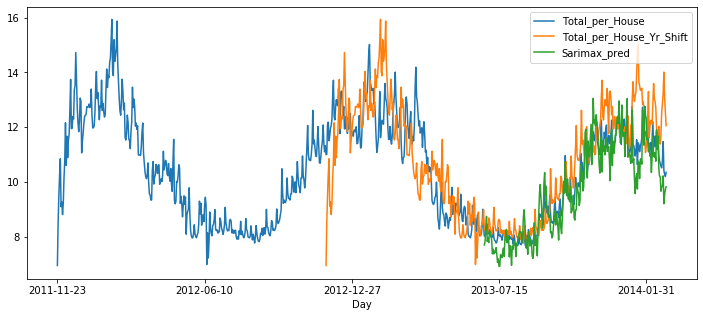

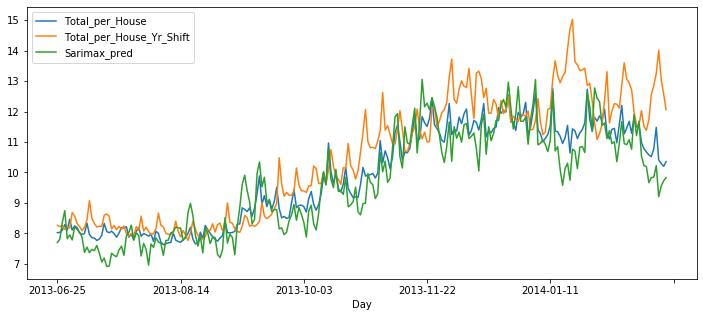

In [57]:
dff[['Total_per_House','Total_per_House_Yr_Shift','Sarimax_pred']].plot(figsize=(12,5))
dff[['Total_per_House','Total_per_House_Yr_Shift','Sarimax_pred']][nn:].plot(figsize=(12,5))

In [58]:
# Run grid search for Affluent
sarimax_gridsearch(dff[['Affluent_diff_yr']][:nn].dropna(), dff[['Average_Temperature_diff_yr']][:nn].dropna(), pdq, pdqs, freq='D')

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (0, 0, 0, 12) : BIC Calculated =873.072145010307
SARIMAX (0, 0, 0) x (0, 0, 1, 12) : BIC Calculated =802.7165046790471
SARIMAX (0, 0, 0) x (0, 1, 0, 12) : BIC Calculated =925.7041851213845
SARIMAX (0, 0, 0) x (0, 1, 1, 12) : BIC Calculated =808.3846732615559
SARIMAX (0, 0, 0) x (1, 0, 0, 12) : BIC Calculated =808.7815177216709
SARIMAX (0, 0, 0) x (1, 0, 1, 12) : BIC Calculated =807.9915717838786

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (0, 0, 0) x (1, 1, 0, 12) : BIC Calculated =860.6591170152313


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (1, 1, 1, 12) : BIC Calculated =803.3615915122856
SARIMAX (0, 0, 1) x (0, 0, 0, 12) : BIC Calculated =732.2605294799192


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 0, 1, 12) : BIC Calculated =669.8483243396522
SARIMAX (0, 0, 1) x (0, 1, 0, 12) : BIC Calculated =779.60251722929


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 1, 1, 12) : BIC Calculated =684.4188895340558
SARIMAX (0, 0, 1) x (1, 0, 0, 12) : BIC Calculated =678.103108082365


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 0, 1, 12) : BIC Calculated =674.0003577062087


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 1, 0, 12) : BIC Calculated =730.2266891400197


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 1, 1, 12) : BIC Calculated =675.2998674753877
SARIMAX (0, 1, 0) x (0, 0, 0, 12) : BIC Calculated =612.336357770897
SARIMAX (0, 1, 0) x (0, 0, 1, 12) : BIC Calculated =576.8324528746393
SARIMAX (0, 1, 0) x (0, 1, 0, 12) : BIC Calculated =693.38589086781

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (0, 1, 0) x (0, 1, 1, 12) : BIC Calculated =583.0499877412257
SARIMAX (0, 1, 0) x (1, 0, 0, 12) : BIC Calculated =579.0530679443283


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 0, 1, 12) : BIC Calculated =579.0275388476191
SARIMAX (0, 1, 0) x (1, 1, 0, 12) : BIC Calculated =626.1780899422984


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 1, 1, 12) : BIC Calculated =589.2039123254702
SARIMAX (0, 1, 1) x (0, 0, 0, 12) : BIC Calculated =607.9485100464343
SARIMAX (0, 1, 1) x (0, 0, 1, 12) : BIC Calculated =572.2907890703415


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 1, 0, 12) : BIC Calculated =695.0430415656845


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 1, 1, 12) : BIC Calculated =582.5857861684088
SARIMAX (0, 1, 1) x (1, 0, 0, 12) : BIC Calculated =579.3351780500922


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 0, 1, 12) : BIC Calculated =574.0655232916753
SARIMAX (0, 1, 1) x (1, 1, 0, 12) : BIC Calculated =629.1754020189444


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 1, 1, 12) : BIC Calculated =585.913892626097
SARIMAX (0, 2, 0) x (0, 0, 0, 12) : BIC Calculated =790.361513916092
SARIMAX (0, 2, 0) x (0, 0, 1, 12) : BIC Calculated =737.1834074575435
SARIMAX (0, 2, 0) x (0, 1, 0, 12) : BIC Calculated =838.853012952245

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (0, 1, 1, 12) : BIC Calculated =744.4035796250229
SARIMAX (0, 2, 0) x (1, 0, 0, 12) : BIC Calculated =740.8558075005111


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (1, 0, 1, 12) : BIC Calculated =737.2679089923047
SARIMAX (0, 2, 0) x (1, 1, 0, 12) : BIC Calculated =771.5011418184877


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (1, 1, 1, 12) : BIC Calculated =742.4021188506166
SARIMAX (0, 2, 1) x (0, 0, 0, 12) : BIC Calculated =616.1417756944707


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 0, 1, 12) : BIC Calculated =576.4783349803943
SARIMAX (0, 2, 1) x (0, 1, 0, 12) : BIC Calculated =697.917243622212


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 1, 1, 12) : BIC Calculated =581.0917819597369


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 0, 0, 12) : BIC Calculated =587.8044405693449


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 0, 1, 12) : BIC Calculated =580.9582429728873


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 1, 0, 12) : BIC Calculated =634.3847777234558


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 1, 1, 12) : BIC Calculated =589.9633546703111
SARIMAX (1, 0, 0) x (0, 0, 0, 12) : BIC Calculated =603.4451359330014
SARIMAX (1, 0, 0) x (0, 0, 1, 12) : BIC Calculated =567.4071572106485

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (1, 0, 0) x (0, 1, 0, 12) : BIC Calculated =686.3630639584173


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (0, 1, 1, 12) : BIC Calculated =577.5028447193753
SARIMAX (1, 0, 0) x (1, 0, 0, 12) : BIC Calculated =566.4497314107088


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 0, 1, 12) : BIC Calculated =571.115183852139
SARIMAX (1, 0, 0) x (1, 1, 0, 12) : BIC Calculated =616.2445084623846


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 1, 1, 12) : BIC Calculated =580.2132596256815
SARIMAX (1, 0, 1) x (0, 0, 0, 12) : BIC Calculated =603.3608074702657


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 0, 1, 12) : BIC Calculated =569.4328725330229
SARIMAX (1, 0, 1) x (0, 1, 0, 12) : BIC Calculated =686.91756169778


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 1, 1, 12) : BIC Calculated =577.4223015527042
SARIMAX (1, 0, 1) x (1, 0, 0, 12) : BIC Calculated =570.8588454147311


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 0, 1, 12) : BIC Calculated =570.631123524276


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 0, 12) : BIC Calculated =621.2561270735094


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 1, 12) : BIC Calculated =579.3338960765557
SARIMAX (1, 1, 0) x (0, 0, 0, 12) : BIC Calculated =611.6313945433487
SARIMAX (1, 1, 0) x (0, 0, 1, 12) : BIC Calculated =577.4046512434438


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 1, 0, 12) : BIC Calculated =698.0539258457663


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 1, 1, 12) : BIC Calculated =586.2985609526912
SARIMAX (1, 1, 0) x (1, 0, 0, 12) : BIC Calculated =576.6144744600726


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 0, 1, 12) : BIC Calculated =577.8117164684004
SARIMAX (1, 1, 0) x (1, 1, 0, 12) : BIC Calculated =624.1639173529715


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 1, 1, 12) : BIC Calculated =589.5128845867638
SARIMAX (1, 1, 1) x (0, 0, 0, 12) : BIC Calculated =611.7838574594764


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 0, 1, 12) : BIC Calculated =569.3686031963483


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 0, 12) : BIC Calculated =689.3341928272241


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 1, 12) : BIC Calculated =585.9509439919923


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 0, 12) : BIC Calculated =575.6597498182061


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 1, 12) : BIC Calculated =573.5528535266079


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 0, 12) : BIC Calculated =627.4033411954808


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 1, 12) : BIC Calculated =588.0476932348893
SARIMAX (1, 2, 0) x (0, 0, 0, 12) : BIC Calculated =718.2892223954117
SARIMAX (1, 2, 0) x (0, 0, 1, 12) : BIC Calculated =674.9370533874608
SARIMAX (1, 2, 0) x (0, 1, 0, 12) : BIC Calculated =798.0733653395531

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (0, 1, 1, 12) : BIC Calculated =681.5089316313791
SARIMAX (1, 2, 0) x (1, 0, 0, 12) : BIC Calculated =674.3512288485724


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 0, 1, 12) : BIC Calculated =676.0153824522106
SARIMAX (1, 2, 0) x (1, 1, 0, 12) : BIC Calculated =712.4197844820003

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 1, 1, 12) : BIC Calculated =683.9225552800384
SARIMAX (1, 2, 1) x (0, 0, 0, 12) : BIC Calculated =615.7860609722359


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 0, 1, 12) : BIC Calculated =578.3002108501348


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 1, 0, 12) : BIC Calculated =702.7383363976545


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 1, 1, 12) : BIC Calculated =584.2072711730102


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 0, 0, 12) : BIC Calculated =582.8833334850211


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 0, 1, 12) : BIC Calculated =581.6367246767765


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 1, 0, 12) : BIC Calculated =633.700371574252


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 1, 1, 12) : BIC Calculated =589.4537814146373


,pdq,pdqs,bic,aic
52,"(1, 0, 0)","(1, 0, 0, 12)",566.449731,556.524928
49,"(1, 0, 0)","(0, 0, 1, 12)",567.407157,557.482354
73,"(1, 1, 1)","(0, 0, 1, 12)",569.368603,556.175334
57,"(1, 0, 1)","(0, 0, 1, 12)",569.432873,556.219653
61,"(1, 0, 1)","(1, 0, 1, 12)",570.631124,554.114599


In [59]:
# I will run the Sarimax model specifically for the Affluent group based on optimal parameter from gridsearch
sxd_affluent = sm.tsa.statespace.SARIMAX(dff['Affluent_diff_yr'][:nn].dropna(), dff['Average_Temperature_diff_yr'][:nn].dropna(), order=(1, 0, 0), seasonal_order=(0, 0, 1, 12), freq='D')
sd_affluent = sxd_affluent.fit()
sd_affluent.summary()
sdp_affluent = sd_affluent.forecast(steps=248, exog= dff['Average_Temperature_diff_yr'][nn:])
# un-difference - the difference for a day is the difference from the year before
udp_affluent = dff['Affluent'][nn:] + sdp_affluent
udp_affluent = pd.DataFrame(udp_affluent)
udp_affluent = udp_affluent.dropna()
udp_affluent.columns = ['Sarimax_pred_affluent']
dff = dff.join(udp_affluent, how='left')
sxd_affluent_error = np.mean(np.abs(dff['Sarimax_pred_affluent'][nn:] - dff['Affluent'][nn:]))


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [60]:
naive_mean_av_error_affluent = np.mean(np.abs(dff['Affluent_Yr_Shift'][nn:] - dff['Affluent'][nn:]))
print('Sarimax model error: {}'.format(sxd_affluent_error))
print('Naive model error: {}'.format(naive_mean_av_error_affluent))

Sarimax model error: 0.6247844125590214
Naive model error: 0.8952131738693858


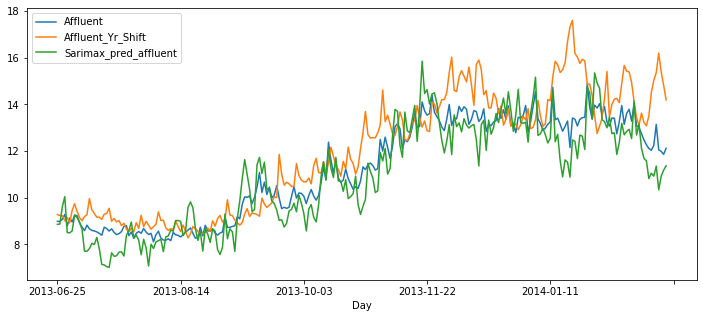

In [61]:
# plot the prediction against naive and test
dff[['Affluent','Affluent_Yr_Shift','Sarimax_pred_affluent']][nn:].plot(figsize=(12,5))

In [62]:
# Run grid search for Comfortable
sarimax_gridsearch(dff[['Comfortable_diff_yr']][:nn].dropna(), dff[['Average_Temperature_diff_yr']][:nn].dropna(), pdq, pdqs, freq='D')

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (0, 0, 0, 12) : BIC Calculated =848.8576579260531
SARIMAX (0, 0, 0) x (0, 0, 1, 12) : BIC Calculated =724.6705142132992
SARIMAX (0, 0, 0) x (0, 1, 0, 12) : BIC Calculated =787.5758312808067
SARIMAX (0, 0, 0) x (0, 1, 1, 12) : BIC Calculated =713.4699923252082
SARIMAX (0, 0, 0) x (1, 0, 0, 12) : BIC Calculated =703.9140049891223
SARIMAX (0, 0, 0) x (1, 0, 1, 12) : BIC Calculated =704.5431403409328

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (0, 0, 0) x (1, 1, 0, 12) : BIC Calculated =735.4954475593321


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (1, 1, 1, 12) : BIC Calculated =685.180486315362
SARIMAX (0, 0, 1) x (0, 0, 0, 12) : BIC Calculated =697.469761003452


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 0, 1, 12) : BIC Calculated =609.1653540117696
SARIMAX (0, 0, 1) x (0, 1, 0, 12) : BIC Calculated =680.5992641035072


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 1, 1, 12) : BIC Calculated =609.9210587868939
SARIMAX (0, 0, 1) x (1, 0, 0, 12) : BIC Calculated =598.7539902436608


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 0, 1, 12) : BIC Calculated =599.2876624556329
SARIMAX (0, 0, 1) x (1, 1, 0, 12) : BIC Calculated =638.2437431535088

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (0, 0, 1) x (1, 1, 1, 12) : BIC Calculated =587.9384133499105
SARIMAX (0, 1, 0) x (0, 0, 0, 12) : BIC Calculated =571.6624563918525
SARIMAX (0, 1, 0) x (0, 0, 1, 12) : BIC Calculated =538.7093424818627


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (0, 1, 0, 12) : BIC Calculated =677.8749269262523


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (0, 1, 1, 12) : BIC Calculated =546.9712791352023
SARIMAX (0, 1, 0) x (1, 0, 0, 12) : BIC Calculated =540.5761460870076


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 0, 1, 12) : BIC Calculated =543.9786551894128
SARIMAX (0, 1, 0) x (1, 1, 0, 12) : BIC Calculated =587.0098928117299


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 1, 1, 12) : BIC Calculated =550.0432748176122
SARIMAX (0, 1, 1) x (0, 0, 0, 12) : BIC Calculated =559.0856424259201
SARIMAX (0, 1, 1) x (0, 0, 1, 12) : BIC Calculated =524.5597970735265

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (0, 1, 1) x (0, 1, 0, 12) : BIC Calculated =672.416362052298


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 1, 1, 12) : BIC Calculated =527.3067881513774
SARIMAX (0, 1, 1) x (1, 0, 0, 12) : BIC Calculated =528.5740153260929


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 0, 1, 12) : BIC Calculated =529.7324308522003
SARIMAX (0, 1, 1) x (1, 1, 0, 12) : BIC Calculated =582.666847620423


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 1, 1, 12) : BIC Calculated =538.417465642654
SARIMAX (0, 2, 0) x (0, 0, 0, 12) : BIC Calculated =759.4036361439667
SARIMAX (0, 2, 0) x (0, 0, 1, 12) : BIC Calculated =715.8574613354792


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (0, 1, 0, 12) : BIC Calculated =837.0916202592947


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (0, 1, 1, 12) : BIC Calculated =717.7842843519282
SARIMAX (0, 2, 0) x (1, 0, 0, 12) : BIC Calculated =718.5274756831558
SARIMAX (0, 2, 0) x (1, 0, 1, 12) : BIC Calculated =720.5540652667034


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (1, 1, 0, 12) : BIC Calculated =749.4626487428114
SARIMAX (0, 2, 0) x (1, 1, 1, 12) : BIC Calculated =721.4496392177535
SARIMAX (0, 2, 1) x (0, 0, 0, 12) : BIC Calculated =580.1703935951329


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 0, 1, 12) : BIC Calculated =544.3897273822432
SARIMAX (0, 2, 1) x (0, 1, 0, 12) : BIC Calculated =683.8309229558342


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 1, 1, 12) : BIC Calculated =552.4276708887016


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 0, 0, 12) : BIC Calculated =549.1345804684053


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 0, 1, 12) : BIC Calculated =549.6561147875739


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 1, 0, 12) : BIC Calculated =595.4205989159777


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 1, 1, 12) : BIC Calculated =557.5549922532548
SARIMAX (1, 0, 0) x (0, 0, 0, 12) : BIC Calculated =561.2520471448169


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (0, 0, 1, 12) : BIC Calculated =526.6686484417365
SARIMAX (1, 0, 0) x (0, 1, 0, 12) : BIC Calculated =652.8691755472184


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (0, 1, 1, 12) : BIC Calculated =531.0692365935679
SARIMAX (1, 0, 0) x (1, 0, 0, 12) : BIC Calculated =526.583228761975


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 0, 1, 12) : BIC Calculated =531.5390199446953
SARIMAX (1, 0, 0) x (1, 1, 0, 12) : BIC Calculated =568.6174493656856


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 1, 1, 12) : BIC Calculated =535.027558402979
SARIMAX (1, 0, 1) x (0, 0, 0, 12) : BIC Calculated =555.6390229774012


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 0, 1, 12) : BIC Calculated =522.8087798118971
SARIMAX (1, 0, 1) x (0, 1, 0, 12) : BIC Calculated =655.5134283781554


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 1, 1, 12) : BIC Calculated =523.5116409207916
SARIMAX (1, 0, 1) x (1, 0, 0, 12) : BIC Calculated =524.3311733923255


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 0, 1, 12) : BIC Calculated =528.0949952459051


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 0, 12) : BIC Calculated =571.4992635042152


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 1, 12) : BIC Calculated =528.3921622597824
SARIMAX (1, 1, 0) x (0, 0, 0, 12) : BIC Calculated =566.2533127168049
SARIMAX (1, 1, 0) x (0, 0, 1, 12) : BIC Calculated =531.8801617976918

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (1, 1, 0) x (0, 1, 0, 12) : BIC Calculated =680.1241537032985


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 1, 1, 12) : BIC Calculated =535.1635277417425
SARIMAX (1, 1, 0) x (1, 0, 0, 12) : BIC Calculated =531.9863388246226


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 0, 1, 12) : BIC Calculated =537.1536429439661
SARIMAX (1, 1, 0) x (1, 1, 0, 12) : BIC Calculated =582.3278410206121


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 1, 1, 12) : BIC Calculated =545.7764993006947
SARIMAX (1, 1, 1) x (0, 0, 0, 12) : BIC Calculated =554.0030643636875


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 0, 1, 12) : BIC Calculated =521.7146260028252


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 0, 12) : BIC Calculated =658.0818500107605


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 1, 12) : BIC Calculated =527.8641081530565
SARIMAX (1, 1, 1) x (1, 0, 0, 12) : BIC Calculated =524.4947630462643


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 1, 12) : BIC Calculated =526.1659494835541


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 0, 12) : BIC Calculated =578.8396701106764


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 1, 12) : BIC Calculated =531.6716589408572
SARIMAX (1, 2, 0) x (0, 0, 0, 12) : BIC Calculated =686.5394590916827
SARIMAX (1, 2, 0) x (0, 0, 1, 12) : BIC Calculated =647.0561027483672
SARIMAX (1, 2, 0) x (0, 1, 0, 12) : BIC Calculated =802.5189998828192

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (1, 2, 0) x (0, 1, 1, 12) : BIC Calculated =645.883896302527
SARIMAX (1, 2, 0) x (1, 0, 0, 12) : BIC Calculated =646.7420290695185


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 0, 1, 12) : BIC Calculated =652.3513962211838
SARIMAX (1, 2, 0) x (1, 1, 0, 12) : BIC Calculated =678.8710810521419

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 1, 1, 12) : BIC Calculated =653.7518485807353


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 0, 0, 12) : BIC Calculated =572.7585267304178
SARIMAX (1, 2, 1) x (0, 0, 1, 12) : BIC Calculated =538.0188544951164


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 1, 0, 12) : BIC Calculated =686.1804658438452


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 1, 1, 12) : BIC Calculated =540.2950942160371


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 0, 0, 12) : BIC Calculated =540.8060847221237


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 0, 1, 12) : BIC Calculated =543.3120790503705


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 1, 0, 12) : BIC Calculated =590.0408775718214


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 1, 1, 12) : BIC Calculated =553.2746436796948


,pdq,pdqs,bic,aic
73,"(1, 1, 1)","(0, 0, 1, 12)",521.714626,508.521357
57,"(1, 0, 1)","(0, 0, 1, 12)",522.808780,509.595560
59,"(1, 0, 1)","(0, 1, 1, 12)",523.511641,510.544653
60,"(1, 0, 1)","(1, 0, 0, 12)",524.331173,511.098103
76,"(1, 1, 1)","(1, 0, 0, 12)",524.494763,511.281543


In [63]:
# I will run the Sarimax model specifically for the Comfortable group based on optimal parameter from gridsearch
sxd_comf = sm.tsa.statespace.SARIMAX(dff['Comfortable_diff_yr'][:nn].dropna(), dff['Average_Temperature_diff_yr'][:nn].dropna(), order=(1, 1, 1), seasonal_order=(0, 0, 1, 12), freq='D')
sd_comf = sxd_comf.fit()
sd_comf.summary()
sdp_comf = sd_comf.forecast(steps=248, exog= dff['Average_Temperature_diff_yr'][nn:])
# un-difference - the difference for a day is the difference from the year before
udp_comf = dff['Comfortable'][nn:] + sdp_comf
udp_comf = pd.DataFrame(udp_comf)
udp_comf = udp_comf.dropna()
udp_comf.columns = ['Sarimax_pred_comfortable']
dff = dff.join(udp_comf, how='left')
sxd_comf_error = np.mean(np.abs(dff['Sarimax_pred_comfortable'][nn:] - dff['Comfortable'][nn:]))
naive_mean_av_error_comf = np.mean(np.abs(dff['Comfortable_Yr_Shift'][nn:] - dff['Comfortable'][nn:]))
print('Sarimax Model Error: {}'.format(sxd_comf_error))
print('Naive Model Error: {}'.format(naive_mean_av_error_comf))

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Sarimax Model Error: 0.418806294007537
Naive Model Error: 0.673871550963003


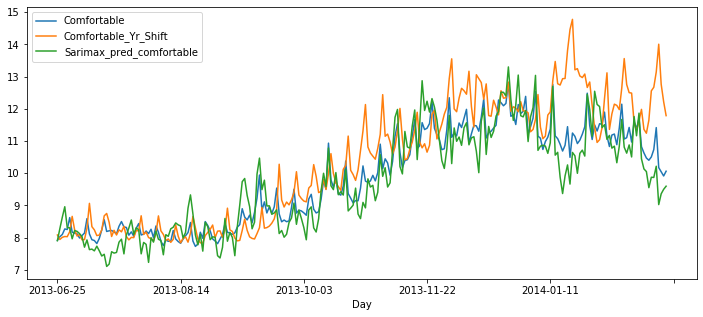

In [64]:
# Plot the test set against the SARIMAX prediction and the naive prediction
dff[['Comfortable','Comfortable_Yr_Shift','Sarimax_pred_comfortable']][nn:].plot(figsize=(12,5))

In [65]:
# Run grid search for Adversity
sarimax_gridsearch(dff[['Adversity_diff_yr']].dropna()[:nn], dff[['Average_Temperature_diff_yr']].dropna()[:nn], pdq, pdqs, freq='D')

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (0, 0, 0, 12) : BIC Calculated =1464.2027447702726
SARIMAX (0, 0, 0) x (0, 0, 1, 12) : BIC Calculated =1340.5352752056888
SARIMAX (0, 0, 0) x (0, 1, 0, 12) : BIC Calculated =1411.2792452775564


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (0, 1, 1, 12) : BIC Calculated =1233.4072767199266
SARIMAX (0, 0, 0) x (1, 0, 0, 12) : BIC Calculated =1301.32113781939


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (1, 0, 1, 12) : BIC Calculated =1244.8383985867915
SARIMAX (0, 0, 0) x (1, 1, 0, 12) : BIC Calculated =1309.5029883536065


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 0) x (1, 1, 1, 12) : BIC Calculated =1216.2135154484185
SARIMAX (0, 0, 1) x (0, 0, 0, 12) : BIC Calculated =1203.698665076634


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 0, 1, 12) : BIC Calculated =1097.7897937465923
SARIMAX (0, 0, 1) x (0, 1, 0, 12) : BIC Calculated =1229.983992333506


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (0, 1, 1, 12) : BIC Calculated =1060.4500448569668
SARIMAX (0, 0, 1) x (1, 0, 0, 12) : BIC Calculated =1073.2841620493023


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 0, 1, 12) : BIC Calculated =1062.0664018698674


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 1, 0, 12) : BIC Calculated =1132.3130460779073


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 0, 1) x (1, 1, 1, 12) : BIC Calculated =1030.8971690316778
SARIMAX (0, 1, 0) x (0, 0, 0, 12) : BIC Calculated =1027.3902664567472
SARIMAX (0, 1, 0) x (0, 0, 1, 12) : BIC Calculated =939.5326380139597

C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



SARIMAX (0, 1, 0) x (0, 1, 0, 12) : BIC Calculated =1328.283528547974


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (0, 1, 1, 12) : BIC Calculated =1015.1152113957903
SARIMAX (0, 1, 0) x (1, 0, 0, 12) : BIC Calculated =948.9043189453616


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 0, 1, 12) : BIC Calculated =934.6613912236843


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 0) x (1, 1, 0, 12) : BIC Calculated =1112.2929335358338
SARIMAX (0, 1, 0) x (1, 1, 1, 12) : BIC Calculated =976.1217006979567
SARIMAX (0, 1, 1) x (0, 0, 0, 12) : BIC Calculated =945.4510972744789


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 0, 1, 12) : BIC Calculated =866.0977852619678
SARIMAX (0, 1, 1) x (0, 1, 0, 12) : BIC Calculated =1272.3009598329204


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (0, 1, 1, 12) : BIC Calculated =927.9781553975321
SARIMAX (0, 1, 1) x (1, 0, 0, 12) : BIC Calculated =882.6311362287842


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 0, 1, 12) : BIC Calculated =862.5672070010783


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 1, 0, 12) : BIC Calculated =1078.9387162616413


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 1, 1) x (1, 1, 1, 12) : BIC Calculated =909.5747673276029
SARIMAX (0, 2, 0) x (0, 0, 0, 12) : BIC Calculated =1472.3406695082263


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (0, 0, 1, 12) : BIC Calculated =1366.3974793978052
SARIMAX (0, 2, 0) x (0, 1, 0, 12) : BIC Calculated =1716.1165605478855


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (0, 1, 1, 12) : BIC Calculated =1433.1942292914725
SARIMAX (0, 2, 0) x (1, 0, 0, 12) : BIC Calculated =1372.244190053856


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (1, 0, 1, 12) : BIC Calculated =1361.364580215944
SARIMAX (0, 2, 0) x (1, 1, 0, 12) : BIC Calculated =1507.3671108367787


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 0) x (1, 1, 1, 12) : BIC Calculated =1391.3690028944322


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 0, 0, 12) : BIC Calculated =1037.3749963261314


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 0, 1, 12) : BIC Calculated =945.2986214905466


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 1, 0, 12) : BIC Calculated =1334.6289573205713


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (0, 1, 1, 12) : BIC Calculated =1025.7813396889806


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 0, 0, 12) : BIC Calculated =960.0325511950365


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 0, 1, 12) : BIC Calculated =941.7300667749371


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 1, 0, 12) : BIC Calculated =1122.905481475008


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (0, 2, 1) x (1, 1, 1, 12) : BIC Calculated =986.3267399297805
SARIMAX (1, 0, 0) x (0, 0, 0, 12) : BIC Calculated =995.5881114860315


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (0, 0, 1, 12) : BIC Calculated =913.4942611859694
SARIMAX (1, 0, 0) x (0, 1, 0, 12) : BIC Calculated =1230.8778680276216


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (0, 1, 1, 12) : BIC Calculated =958.9313062517695
SARIMAX (1, 0, 0) x (1, 0, 0, 12) : BIC Calculated =917.7459632541265


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 0, 1, 12) : BIC Calculated =910.1287300988948


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 1, 0, 12) : BIC Calculated =1038.9356006408543


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 0) x (1, 1, 1, 12) : BIC Calculated =935.7569341220552
SARIMAX (1, 0, 1) x (0, 0, 0, 12) : BIC Calculated =943.3683852143535


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 0, 1, 12) : BIC Calculated =868.9738032964707


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 1, 0, 12) : BIC Calculated =1227.5280893827269


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (0, 1, 1, 12) : BIC Calculated =922.1611514204899


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 0, 0, 12) : BIC Calculated =880.5294634067908


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 0, 1, 12) : BIC Calculated =863.676092766374


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 0, 12) : BIC Calculated =1038.594173787271


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 0, 1) x (1, 1, 1, 12) : BIC Calculated =905.0490313597675
SARIMAX (1, 1, 0) x (0, 0, 0, 12) : BIC Calculated =984.5272561804322


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 0, 1, 12) : BIC Calculated =895.214326898416
SARIMAX (1, 1, 0) x (0, 1, 0, 12) : BIC Calculated =1318.1434318467898


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (0, 1, 1, 12) : BIC Calculated =962.9921204517137
SARIMAX (1, 1, 0) x (1, 0, 0, 12) : BIC Calculated =908.1229282204639


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 0, 1, 12) : BIC Calculated =895.6691875053467


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 1, 0, 12) : BIC Calculated =1089.6275086021853


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 0) x (1, 1, 1, 12) : BIC Calculated =938.5506176924441
SARIMAX (1, 1, 1) x (0, 0, 0, 12) : BIC Calculated =935.9356341183261


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 0, 1, 12) : BIC Calculated =858.5876881918988


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 0, 12) : BIC Calculated =1237.9235387656659


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (0, 1, 1, 12) : BIC Calculated =922.3198296819887


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 0, 12) : BIC Calculated =873.0575096098556


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 0, 1, 12) : BIC Calculated =853.8761729661311


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 0, 12) : BIC Calculated =1049.833808035336


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 1, 1) x (1, 1, 1, 12) : BIC Calculated =901.3040216180203
SARIMAX (1, 2, 0) x (0, 0, 0, 12) : BIC Calculated =1296.3813490607822


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (0, 0, 1, 12) : BIC Calculated =1179.4939631879613
SARIMAX (1, 2, 0) x (0, 1, 0, 12) : BIC Calculated =1640.2499314061422


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (0, 1, 1, 12) : BIC Calculated =1255.3642222999263
SARIMAX (1, 2, 0) x (1, 0, 0, 12) : BIC Calculated =1188.7850761479704


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 0, 1, 12) : BIC Calculated =1184.529582651578


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 1, 0, 12) : BIC Calculated =1335.6088817522036


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 0) x (1, 1, 1, 12) : BIC Calculated =1213.6054097840124


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 0, 0, 12) : BIC Calculated =992.148402842558


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 0, 1, 12) : BIC Calculated =903.280913912984


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (0, 1, 0, 12) : BIC Calculated =1324.424581384203
SARIMAX (1, 2, 1) x (0, 1, 1, 12) : BIC Calculated =973.317662102145


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 0, 0, 12) : BIC Calculated =919.3356489578844


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 0, 1, 12) : BIC Calculated =903.2810169771159


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 1, 0, 12) : BIC Calculated =1099.8962285925818


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMAX (1, 2, 1) x (1, 1, 1, 12) : BIC Calculated =949.0187313747177


,pdq,pdqs,bic,aic
77,"(1, 1, 1)","(1, 0, 1, 12)",853.876173,833.352207
73,"(1, 1, 1)","(0, 0, 1, 12)",858.587688,842.168515
29,"(0, 1, 1)","(1, 0, 1, 12)",862.567207,846.148034
61,"(1, 0, 1)","(1, 0, 1, 12)",863.676093,843.140978
25,"(0, 1, 1)","(0, 0, 1, 12)",866.097785,853.783406


In [66]:
# I will run the Sarimax model specifically for the Adversity group based on optimal parameter from gridsearch
sxd_adv = sm.tsa.statespace.SARIMAX(dff['Adversity_diff_yr'][:nn].dropna(), dff['Average_Temperature_diff_yr'][:nn].dropna(), order=(1, 1, 1), seasonal_order=(0, 0, 1, 12), freq='D')
sd_adv = sxd_adv.fit()
sd_adv.summary()
sdp_adv = sd_adv.forecast(steps=248, exog= dff['Average_Temperature_diff_yr'][nn:])
# un-difference - the difference for a day is the difference from the year before
udp_adv = dff['Adversity'][nn:] + sdp_adv
udp_adv = pd.DataFrame(udp_adv)
udp_adv = udp_adv.dropna()
udp_adv.columns = ['Sarimax_pred_adversity']
dff = dff.join(udp_adv, how='left')


C:\Users\james\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [67]:
sxd_adv_error = np.mean(np.abs(dff['Sarimax_pred_adversity'][nn:] - dff['Adversity'][nn:]))
naive_mean_av_error_adv = np.mean(np.abs(dff['Adversity_Yr_Shift'][nn:] - dff['Adversity'][nn:]))
print('Sarimax Model Error: {}'.format(sxd_adv_error))
print('Naive Model Error: {}'.format(naive_mean_av_error_adv))

Sarimax Model Error: 0.4139014017267722
Naive Model Error: 0.5033537582261344


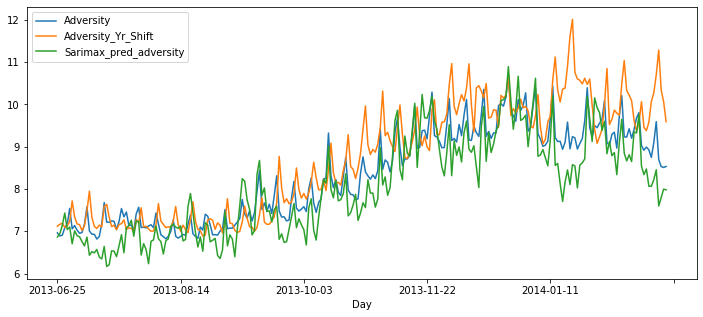

In [68]:
dff[['Adversity','Adversity_Yr_Shift','Sarimax_pred_adversity']][nn:].plot(figsize=(12,5))